In [1]:
%%capture
%pip install transformers datasets

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

I'm going to implement both a multi-headed transformer model (with complexity o($n^{2}$)) and the Linformer model with complexity $o(nd)$ with d an integer > 0. This implementation is based on the paper "Linformer: Self-Attention with Linear Complexity" 

## DATASET
AG_News is a Dataset of short news articles which are classified in fours different categories. We will train both a traditionnal multi-headed transformer model and Linform on a classification task 

In [3]:
from datasets import load_dataset
import unicodedata
import re

dataset = load_dataset("fancyzhx/ag_news",split='train')

from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)

print(dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})


C:\Users\1411\anaconda3\envs\env_name\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["text"],
        add_special_tokens=True,
        truncation=True,
        max_length=512,
        padding='max_length',
        return_attention_mask=False,
    )
    return x

In [5]:
n_samples = 50000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)

# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=256, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

In [7]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)



## Multi-Head Transformer for Classification

In [8]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d, n_heads, dropout=0.3):
        super().__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"
        
        self.n_heads = n_heads
        self.d_heads = d // n_heads  # Dimension per head

        self.q_proj = nn.Linear(d, d)
        self.k_proj = nn.Linear(d, d)
        self.v_proj = nn.Linear(d, d)
        self.out_proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, d = x.shape
        d_heads = self.d_heads

        # Linear projections
        q = self.q_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)
        k = self.k_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)
        v = self.v_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)

        # Attention scores
        score = torch.softmax(q @ k.transpose(-1, -2) * (d_heads**-0.5), dim=-1)
        score = self.dropout(score)  # Apply dropout to attention scores

        # Attention output
        attention = score @ v  # (B, H, L, D_head)
        attention = attention.transpose(1, 2).reshape(batch_size, seq_len, d)  # Merge heads

        # Output projection
        attention = self.out_proj(attention)  # Project back to original embedding dimension
        return attention


class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),  
            nn.Dropout(dropout),  
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class TransformerLayer(nn.Module):
    def __init__(self, d, d_ff, seq_len, dropout=0.3, n_heads=8):
        super().__init__()
        self.attention = Multi_Head_Attention(d, n_heads, dropout)
        self.feedforward = FeedForward(d, d_ff, d, dropout=dropout)
        self.pre_attention_norm = nn.LayerNorm(d)
        self.post_attention_norm = nn.LayerNorm(d)

    def forward(self, x):
        # Normalize and apply Multi-Head Attention
        normed_x = self.pre_attention_norm(x)
        attention_output = self.attention(normed_x)  # (B, L, d)
        x = x + attention_output  

        # Normalize and apply Feedforward Network
        normed_x = self.post_attention_norm(x)
        ff_output = self.feedforward(normed_x)
        return x + ff_output  


class Transformer_Classif(nn.Module):
    def __init__(self, d, d_ff, n_classes, vocab_size, max_len=256, drop=0.3, num_layers=4, n_heads=8):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, d)
        self.position_embeddings = nn.Embedding(num_embeddings=max_len + 1, embedding_dim=d)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d))  # CLS token
        self.dropout = nn.Dropout(drop)

        # Stack of Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d, d_ff, max_len, drop, n_heads) for _ in range(num_layers)
        ])
        self.out_norm = nn.LayerNorm(d)
        self.classifier = nn.Linear(d, n_classes)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)

        # Token + Positional embeddings
        word_embeddings = self.word_embeddings(x)  # (B, L, d)
        position_ids = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)  # (B, L)
        position_embeddings = self.position_embeddings(position_ids)  # (B, L, d)
        embeddings = self.dropout(word_embeddings + position_embeddings)

        # Add [CLS] token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (B, 1, d)
        x = torch.cat((cls_tokens, embeddings), dim=1)  # (B, L+1, d)

        # Loop Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)

        # Final [CLS] token representation
        cls_representation = x[:, 0]  # (B, d)
        return self.classifier(cls_representation)  # (B, n_classes)


In [9]:
# Testing
batch_size = 4
seq_len = 16
vocab_size = 1000
embedding_dim = 200
hidden_dim = 400
n_classes = 5

x = torch.randint(0, vocab_size, (batch_size, seq_len))

# Initialize model
model = Transformer_Classif(d=embedding_dim, d_ff=hidden_dim, n_classes=n_classes, vocab_size=vocab_size)


logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([4, 5])
Logits: tensor([[-0.0315,  0.1666,  0.8459,  0.6414,  0.7568],
        [ 0.5307, -0.1839,  0.5046,  0.4103,  0.5138],
        [-0.0732, -0.1637,  0.5645,  0.7635,  0.4638],
        [ 0.3576, -0.3100,  0.6191,  0.6565,  0.5188]],
       grad_fn=<AddmmBackward0>)


## Linformer 

In [10]:
class LinearAttentionHead(nn.Module):
    def __init__(self, dim, dropout, E_proj, F_proj):
        super(LinearAttentionHead, self).__init__()
        self.E = E_proj
        self.F = F_proj
        self.dim = dim
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V):
        
        batch_size, n_heads, seq_len, head_dim = Q.shape

        E = self.E[:seq_len, :].to(K.device)  # Adjust to seq_len
        F = self.F[:seq_len, :].to(V.device)  # Adjust to seq_len

        # Project K and V
        K = K.transpose(-2, -1)  # (batch_size, n_heads, head_dim, seq_len)
        K = K @ E  # (batch_size, n_heads, head_dim, k_dim)
        V = V.transpose(-2, -1)  # (batch_size, n_heads, head_dim, seq_len)
        V = V @ F  # (batch_size, n_heads, head_dim, k_dim)

        # Compute attention scores
        Q = Q @ K  # (batch_size, n_heads, seq_len, k_dim)
        P_bar = Q / torch.sqrt(torch.tensor(self.dim, dtype=Q.dtype).to(Q.device))
        P_bar = P_bar.softmax(dim=-1)
        P_bar = self.dropout(P_bar)

        # Apply attention scores to V
        out_tensor = P_bar @ V.transpose(-2, -1)  # (batch_size, n_heads, seq_len, head_dim)
        return out_tensor


class MHAttention(nn.Module):
    def __init__(self, input_size, dim, channels, dim_k, nhead, dropout):
        super(MHAttention, self).__init__()
        
        self.nhead = nhead
        self.head_dim = dim
        self.dim_k = dim_k
        self.channels = channels
        self.w_o = nn.Linear(dim * nhead, channels)

        # Define shared projection matrices
        self.E_proj = nn.Parameter(torch.randn(input_size, dim_k))
        self.F_proj = nn.Parameter(torch.randn(input_size, dim_k))
        nn.init.xavier_uniform_(self.E_proj)
        nn.init.xavier_uniform_(self.F_proj)

        # Define query, key, value projection layers
        self.to_q = nn.Linear(channels, dim * nhead, bias=False)
        self.to_k = nn.Linear(channels, dim * nhead, bias=False)
        self.to_v = nn.Linear(channels, dim * nhead, bias=False)
        self.mh_dropout = nn.Dropout(dropout)

        # Create a single LinearAttentionHead for all heads
        self.attention_head = LinearAttentionHead(dim, dropout, self.E_proj, self.F_proj)

    def forward(self, tensor):
        batch_size, seq_len, _ = tensor.shape

        # Project input to queries, keys, values
        Q = self.to_q(tensor).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_dim)
        K = self.to_k(tensor).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_dim)
        V = self.to_v(tensor).view(batch_size, seq_len, self.nhead, self.head_dim).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_dim)

        # Compute attention
        out = self.attention_head(Q, K, V)  # (batch_size, n_heads, seq_len, head_dim)

        # Merge heads and project to output
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)  # (batch_size, seq_len, dim * n_heads)
        out = self.w_o(out)
        out = self.mh_dropout(out)
        return out



class TransformerLayer_Linformer(nn.Module):
    def __init__(self, d, d_ff, seq_len, k_dim, dropout=0.3, n_heads=8):
        super().__init__()
        self.attention = MHAttention(
            input_size=seq_len + 1,  # +1 for CLS token
            dim=d // n_heads,  # Dimension per head
            channels=d,  # Input channels (embedding size)
            dim_k=k_dim,  # Projected key dimension
            nhead=n_heads,  # Number of heads
            dropout=dropout
        )
        self.feedforward = FeedForward(d, 4 * d, d, dropout=dropout)
        self.pre_attention_norm = nn.LayerNorm(d)
        self.post_attention_norm = nn.LayerNorm(d)

    def forward(self, x):
        # Attention with residual connection
        normed_x = self.pre_attention_norm(x)
        attention = self.attention(normed_x)  
        y = x + attention

        # Feedforward with residual connection
        normed_y = self.post_attention_norm(y)
        ff_y = self.feedforward(normed_y)
        return normed_y + ff_y 


class Transformer_Classif_Linformer(nn.Module):
    def __init__(self, d, d_ff, n_classes, vocab_size, max_len=512, k_dim=128, drop=0.3, num_layers=4, n_heads=8):
        super().__init__()
        self.wordembeddings = nn.Embedding(vocab_size, d)
        self.position_embeddings = nn.Embedding(num_embeddings=max_len + 1, embedding_dim=d)  # Include CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d))  # Classification token
        self.dropout = nn.Dropout(drop)

        # stack of Linformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer_Linformer(d, d_ff, max_len, k_dim, drop, n_heads) for _ in range(num_layers)
        ])
        self.out_norm = nn.LayerNorm(d)
        self.classif = nn.Linear(d, n_classes)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Word and positional embeddings
        X = self.wordembeddings(x)  # (B, L, d)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        position_vectors = self.position_embeddings(positions)  # (B, L, d)
        X = self.dropout(X + position_vectors)

        # Add classification token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (B, 1, d)
        X = torch.cat((cls_tokens, X), dim=1)  # (B, L+1, d)

        # Loop over Transformer layer
        for layer in self.transformer_layers:
            X = layer(X)

        # Extract [CLS] token representation
        cls_representation = X[:, 0] # (B, d)

        # Classification layer
        logits = self.classif(cls_representation)  # (B, n_classes)
        return logits


In [11]:
# Testing
batch_size = 10
seq_len = 512
vocab_size = 30522
embedding_dim = 512
hidden_dim = 4 * embedding_dim
n_classes = 4
dropout = 0.2
num_layers = 1
n_heads = 8
k_dim = 16  

x = torch.randint(0, vocab_size, (batch_size, seq_len))

# Initialize model
model = Transformer_Classif_Linformer(
    d=embedding_dim,
    d_ff=hidden_dim,
    n_classes=n_classes,
    vocab_size=vocab_size,
    max_len=seq_len,
    k_dim=k_dim,
    drop=dropout,
    num_layers=num_layers,
    n_heads=n_heads
)


logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([10, 4])
Logits: tensor([[-0.7001, -0.1842,  0.6925,  0.1025],
        [-0.7159, -0.2735,  0.8170,  0.0547],
        [-0.6198, -0.2984,  0.7886,  0.0110],
        [-0.8138, -0.2645,  0.7247, -0.0891],
        [-0.8930, -0.1812,  0.6019, -0.1581],
        [-0.6633, -0.0387,  0.6554,  0.0841],
        [-0.6547, -0.3323,  0.8185, -0.0456],
        [-0.7292, -0.3677,  0.7372,  0.1387],
        [-0.6178, -0.3146,  0.7549,  0.0382],
        [-0.7277, -0.3136,  0.6360, -0.0366]], grad_fn=<AddmmBackward0>)


## Training

In [12]:
def compute_accuracy(predictions, labels):
    pred = predictions.argmax(dim=1)  # (batch_size,)
    # Compare with true class indices
    correct = (labels == pred).sum().item()
    return correct

def train_one_epoch(dataloader, model, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        probs = model(batch["input_ids"])  # (batch_size, n_classes)
        gold = batch["label"]  # (batch_size,)

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  
    return avg_loss, avg_accuracy


def validation_step(dataloader,model, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            probs = model(batch["input_ids"])
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold)
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  
    return avg_loss, avg_accuracy

def train(model, train_dataloader, valid_dataloader, lr=0.0005, n_epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

### Classic Transformer training

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7678, train_accuracy: 68.8600, valid_loss: 0.5347, valid_accuracy: 81.5300


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.4824, train_accuracy: 82.4800, valid_loss: 0.4242, valid_accuracy: 85.6700


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3932, train_accuracy: 86.1775, valid_loss: 0.3943, valid_accuracy: 86.4300


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss: 0.3403, train_accuracy: 88.0925, valid_loss: 0.3891, valid_accuracy: 87.0100


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss: 0.2975, train_accuracy: 89.5075, valid_loss: 0.3657, valid_accuracy: 87.9500
Time to train : 393.55s


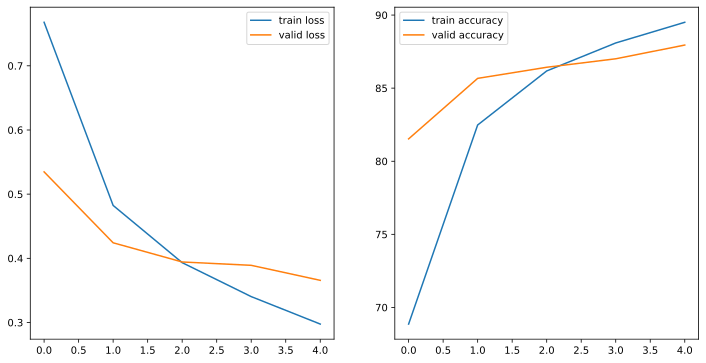

In [13]:
#Parameters
embedding_dim = 256
hidden_dim = 4*embedding_dim
n_classes = 4
vocab_size = 30522
max_len = 512
dropout = 0.15
num_layers = 2
n_heads = 8

#Initialize model
model = Transformer_Classif(embedding_dim, hidden_dim, n_classes, vocab_size,max_len,dropout,num_layers,n_heads)
model = model.to(device)

#Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model, train_dataloader, valid_dataloader,lr=0.0005, n_epochs=5)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")

### Linformer training

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.9067, train_accuracy: 59.4800, valid_loss: 0.4636, valid_accuracy: 83.7000


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.4331, train_accuracy: 84.4400, valid_loss: 0.3733, valid_accuracy: 86.8000


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3441, train_accuracy: 88.0300, valid_loss: 0.3664, valid_accuracy: 87.5300


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss: 0.2896, train_accuracy: 89.9650, valid_loss: 0.3257, valid_accuracy: 88.6600


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss: 0.2593, train_accuracy: 90.9825, valid_loss: 0.3101, valid_accuracy: 89.2100
Time to train : 217.34s


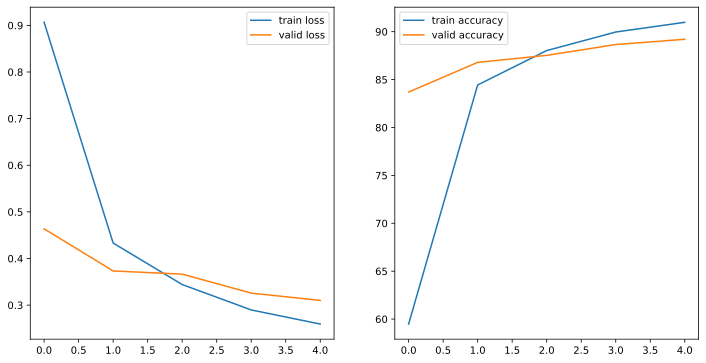

In [14]:
# Parameters
embedding_dim = 256
seq_len = 512
vocab_size = 30522
hidden_dim = 4 * embedding_dim
n_classes = 4
dropout = 0.15
num_layers = 1
n_heads = 8
k_dim = 32



# Initialize model
model = Transformer_Classif_Linformer(
    d=embedding_dim,
    d_ff=hidden_dim,
    n_classes=n_classes,
    vocab_size=vocab_size,
    max_len=seq_len,
    k_dim=k_dim,
    drop=dropout,
    num_layers=num_layers,
    n_heads=n_heads
)
model.to(device)

#Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model, train_dataloader, valid_dataloader,lr=0.0005, n_epochs=5)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")

### Conclusion : 

In this setting, Linformer gives slightly better result than the traditional transformer model while being about 45% faster. It could be much faster than the usual transformer model, but since the sequences lenght are quite low (only 512), it only improves the speed by this much. 